In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time
import os

In [2]:
np.random.seed(7)

In [3]:
#load gdp data
df = pd.read_csv('GDP.csv', index_col=0)

df.head()

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [4]:
#set look-back to 12 and forecast out to 2 
LOOK_BACK = 12
FORECAST_OUT = 2

In [5]:
# get rid of any nan values just in case
df.fillna(method='ffill', inplace=True)

In [6]:
df.head()

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [7]:
# see statistics of the dataset
df.describe()

,GDP
count,291.000000
mean,6143.537649
std,6239.150629
min,243.164000
25%,723.990500
50%,3578.848000
75%,10597.058000
max,21542.104000


In [8]:
# set train-test-split percent to 80%
TRAIN_PCT = 0.80

#split gdp data into train and validation(test) data
train_data = df[:int(TRAIN_PCT * df.shape[0])]
valid_data = df[int(TRAIN_PCT * df.shape[0]):]

print(train_data.shape)
print(valid_data.shape)

# normalize (scale) gdp date between 0 and 1
gdp_scaler = preprocessing.MinMaxScaler()

scaled_train_gdp = gdp_scaler.fit_transform(train_data[['GDP']].values)
scaled_valid_gdp = gdp_scaler.transform(valid_data[['GDP']].values)


scaled_train_data = pd.DataFrame(
    np.concatenate([scaled_train_gdp], axis=1), 
    columns=['GDP']
    )

scaled_valid_data = pd.DataFrame(
    np.concatenate([scaled_valid_gdp], axis=1), 
    columns=['GDP']
    )

#clean any nan values
scaled_train_data.dropna(inplace=True)
scaled_valid_data.dropna(inplace=True)

print(scaled_train_data.shape)
print(scaled_valid_data.shape)

(232, 1)
(59, 1)
(232, 1)
(59, 1)


In [9]:
# function for processing the data to make it compatible with LSTM model

def processData(data, lb, fc_out):

    if isinstance(data, pd.DataFrame):
        data = data.values

    X, y = [], []

    for i in range(len(data)-lb-1):

        if data.shape[1] > 1:
            X.append(data[i:(i+lb), :-1])

        elif data.shape[1] == 1:
            X.append(data[i:(i+lb), 0])

        y.append(data[(i+lb):(i+lb+fc_out), 0])

    X, y = np.array(X), np.array(y)

    if data.shape[1] == 1:
        X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y

In [10]:
# get processed train and test data
train_X, train_y = processData(scaled_train_data, LOOK_BACK, FORECAST_OUT)
valid_X, valid_y = processData(scaled_valid_data, LOOK_BACK, FORECAST_OUT)

print(f"train_X: {train_X.shape}\ntrain_y: {train_y.shape}\nvalid_X: {valid_X.shape}\nvalid_y: {valid_y.shape}")

train_X: (217, 12, 1)
train_y: (217, 2)
valid_X: (44, 12, 1)
valid_y: (44, 2)


In [11]:
type(train_y)
train_y

array([[0.00306729, 0.00384543],
       [0.00384543, 0.00529258],
       [0.00529258, 0.0062529 ],
       [0.0062529 , 0.00756039],
       [0.00756039, 0.00821922],
       [0.00821922, 0.00881332],
       [0.00881332, 0.00920365],
       [0.00920365, 0.00950025],
       [0.00950025, 0.00959879],
       [0.00959879, 0.01014206],
       [0.01014206, 0.0112098 ],
       [0.0112098 , 0.01179354],
       [0.01179354, 0.01210048],
       [0.01210048, 0.01205341],
       [0.01205341, 0.01162985],
       [0.01162985, 0.01157895],
       [0.01157895, 0.01164215],
       [0.01164215, 0.01203916],
       [0.01203916, 0.01275077],
       [0.01275077, 0.01383707],
       [0.01383707, 0.01452596],
       [0.01452596, 0.01523357],
       [0.01523357, 0.01579313],
       [0.01579313, 0.01600927],
       [0.01600927, 0.0165194 ],
       [0.0165194 , 0.01694133],
       [0.01694133, 0.01769642],
       [0.01769642, 0.0184551 ],
       [0.0184551 , 0.01863801],
       [0.01863801, 0.01924595],
       [0.

In [12]:
train_X

array([[[0.00000000e+00],
        [2.28352504e-04],
        [5.22914205e-04],
        ...,
        [2.29549645e-03],
        [2.42074828e-03],
        [2.23653524e-03]],

       [[2.28352504e-04],
        [5.22914205e-04],
        [1.35032556e-03],
        ...,
        [2.42074828e-03],
        [2.23653524e-03],
        [3.06728556e-03]],

       [[5.22914205e-04],
        [1.35032556e-03],
        [1.83871000e-03],
        ...,
        [2.23653524e-03],
        [3.06728556e-03],
        [3.84542685e-03]],

       ...,

       [[8.20624384e-01],
        [8.30331809e-01],
        [8.33088815e-01],
        ...,
        [8.81836374e-01],
        [8.90961028e-01],
        [9.01496515e-01]],

       [[8.30331809e-01],
        [8.33088815e-01],
        [8.43263939e-01],
        ...,
        [8.90961028e-01],
        [9.01496515e-01],
        [9.22218528e-01]],

       [[8.33088815e-01],
        [8.43263939e-01],
        [8.43139502e-01],
        ...,
        [9.01496515e-01],
        [9.2221

In [13]:
#create LSTM model
model = Sequential()

model.add(LSTM(512, input_shape=(train_X.shape[1:]), activation='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(FORECAST_OUT))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# use ADAM as model optimizer and set learning rate to 0.003
opt = Adam(lr=0.003)

model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mse', 'accuracy'])

# save model training checkpoit to this path
file_path = './models/model_checkpoint_weights.h5'

# use ModelCheckpoint while training to save the best trained version of the model
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)

#stop the model early if not making big enough progress
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)

#reduce learning rate if not making big enough progress
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3,
                              patience=5, min_lr=0.0009)
#combine all 3 callbacks
callbacks = [early_stopping, callback_checkpoint, reduce_lr]

#train the model
history = model.fit(train_X, train_y, epochs=100, validation_data=(valid_X, valid_y), callbacks=callbacks, shuffle=True)

Train on 217 samples, validate on 44 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
217/217 [==============================] - 3s 12ms/sample - loss: 0.0756 - mean_squared_error: 0.0756 - acc: 0.5346 - val_loss: 0.6840 - val_mean_squared_error: 0.6840 - val_acc: 0.9318
Epoch 2/100
217/217 [==============================] - 1s 7ms/sample - loss: 0.0718 - mean_squared_error: 0.0718 - acc: 0.6083 - val_loss: 0.9632 - val_mean_squared_error: 0.9632 - val_acc: 0.0682
Epoch 3/100
217/217 [==============================] - 1s 7ms/sample - loss: 0.0499 - mean_squared_error: 0.0499 - acc: 0.0461 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - val_acc: 0.0682
Epoch 4/100
217/217 [==============================] - 1s 7ms/sample - loss: 0.0143 - mean_squared_error: 0.0143 - acc: 0.4055 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_acc: 0.9318
Epoch 5/100
217/217 [==============================] - 1s 7ms/sample - l

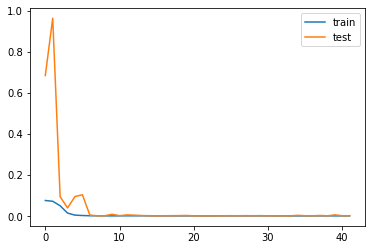

In [15]:
#plot loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
# load the best model saved by ModelCheckpoint
model.load_weights(f'{file_path}')
os.remove(file_path)

In [18]:
def predict(input_value):

    Xt = model.predict(input_value.reshape(1, input_value.shape[0], input_value.shape[1]))
 
    return gdp_scaler.inverse_transform(Xt)[0][0]

In [20]:
#function for saving the model
def save_model(model, filepath):
    model.save(filepath)
    print(f'model saved at {filepath}')

In [21]:
# save model
save_model(model, f"./models/lstm-model[{time.time()}].h5")

model saved at ./models/lstm-model[1575306167.1460094].h5
